In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
import pandas as pd
import os
from glob import glob


if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.2  Device :  cuda


In [2]:
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [3]:
import pickle

# 파일 불러오기
data = pd.read_pickle('./data/train_nona.pkl')
#train = pd.read_excel('./data/train_nona.xlsx')
#submission = pd.read_csv('./data/sample_submission.csv')

In [4]:
data.head()

,측정기기,"시,도",년,월,일,시,시간대,연령,연령대,성별,피부타입,수분,유분,탄력,평균 기온,강수량,평균 풍속,평균 습도,일조합,미세먼지
0,스킨터치1,광주광역시,2014,3,29,19,저녁,21.0,20.0,여자,4.0,99.0,32,92.0,8.6,101.7,2.0,61.0,213.4,49.0
1,스킨터치1,서울특별시,2012,12,29,20,저녁,22.0,20.0,여자,6.0,99.0,87,92.0,-4.1,41.4,2.7,57.0,193.6,41.0
2,스킨터치1,서울특별시,2013,12,18,20,저녁,22.0,20.0,여자,3.0,99.0,6,92.0,-0.2,24.7,2.4,60.0,184.4,55.0
3,스킨터치1,부산광역시,2013,8,31,15,오후,22.0,20.0,여자,4.0,99.0,40,92.0,28.0,144.5,3.3,67.0,286.5,47.0
4,스킨터치1,부산광역시,2012,7,29,18,저녁,23.0,20.0,여자,4.0,99.0,46,92.0,25.5,502.0,3.3,78.0,221.4,40.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 513528 entries, 0 to 553047
Data columns (total 20 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   측정기기    513528 non-null  object 
 1   시,도     513528 non-null  object 
 2   년       513528 non-null  int64  
 3   월       513528 non-null  int64  
 4   일       513528 non-null  int64  
 5   시       513528 non-null  int64  
 6   시간대     513528 non-null  object 
 7   연령      513528 non-null  float64
 8   연령대     513528 non-null  float64
 9   성별      513528 non-null  object 
 10  피부타입    513528 non-null  float64
 11  수분      513528 non-null  float64
 12  유분      513528 non-null  int64  
 13  탄력      513528 non-null  float64
 14  평균 기온   513528 non-null  float64
 15  강수량     513528 non-null  float64
 16  평균 풍속   513528 non-null  float64
 17  평균 습도   513528 non-null  float64
 18  일조합     513528 non-null  float64
 19  미세먼지    513528 non-null  float64
dtypes: float64(11), int64(5), object(4)
memory usage

# 컬럼 정리

- 시,도 년 월 일 시 제거
- category 변환

In [6]:
data.drop(['년','월','일','시'],axis=1,inplace=True)
data.head()

,측정기기,"시,도",시간대,연령,연령대,성별,피부타입,수분,유분,탄력,평균 기온,강수량,평균 풍속,평균 습도,일조합,미세먼지
0,스킨터치1,광주광역시,저녁,21.0,20.0,여자,4.0,99.0,32,92.0,8.6,101.7,2.0,61.0,213.4,49.0
1,스킨터치1,서울특별시,저녁,22.0,20.0,여자,6.0,99.0,87,92.0,-4.1,41.4,2.7,57.0,193.6,41.0
2,스킨터치1,서울특별시,저녁,22.0,20.0,여자,3.0,99.0,6,92.0,-0.2,24.7,2.4,60.0,184.4,55.0
3,스킨터치1,부산광역시,오후,22.0,20.0,여자,4.0,99.0,40,92.0,28.0,144.5,3.3,67.0,286.5,47.0
4,스킨터치1,부산광역시,저녁,23.0,20.0,여자,4.0,99.0,46,92.0,25.5,502.0,3.3,78.0,221.4,40.0


In [7]:
x_col=list(set(data.columns)-set(['수분']))
X=data[x_col].copy()
Y=data[['수분']].copy()

# 데이터 분할

- 6:2:2

In [8]:
from sklearn.model_selection import train_test_split # train , test 분리에 사용.


X, X_test, Y, Y_test=train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=456)

X_train,X_valid,Y_train,Y_valid = train_test_split(X, Y, test_size=0.25, shuffle=True, random_state=456)

print("train : {} ".format(X_train.shape))
print("valid : {} ".format(X_valid.shape))
print("test : {} ".format(X_test.shape))


train : (308116, 15) 
valid : (102706, 15) 
test : (102706, 15) 


인덱스 초기화

In [9]:
X_train.reset_index(inplace=True)
X_train.drop(['index'],axis=1,inplace=True)
Y_train.reset_index(inplace=True)
Y_train.drop(['index'],axis=1,inplace=True)

X_valid.reset_index(inplace=True)
X_valid.drop(['index'],axis=1,inplace=True)
Y_valid.reset_index(inplace=True)
Y_valid.drop(['index'],axis=1,inplace=True)


X_test.reset_index(inplace=True)
X_test.drop(['index'],axis=1,inplace=True)
Y_test.reset_index(inplace=True)
Y_test.drop(['index'],axis=1,inplace=True)

# 정규화

- 수치형

In [10]:
from sklearn.preprocessing import MinMaxScaler

numerics = ['연령','유분','탄력','평균 기온','강수량','평균 풍속','평균 습도','일조합','미세먼지']

sc = MinMaxScaler()

X_train[numerics] = sc.fit_transform(X_train[numerics])
X_valid[numerics] = sc.transform(X_valid[numerics])
X_test[numerics] = sc.transform(X_test[numerics])


# categorical 변환

In [11]:


categories = ['측정기기','시,도','시간대','연령대','성별','피부타입']

train_categories=pd.get_dummies(X_train[categories])
X_train.drop(categories,axis=1,inplace=True)

valid_categories=pd.get_dummies(X_valid[categories])
X_valid.drop(categories,axis=1,inplace=True)

test_categories=pd.get_dummies(X_test[categories])
X_test.drop(categories,axis=1,inplace=True)

X_train=pd.concat([X_train,train_categories],axis=1).copy()

X_valid=pd.concat([X_valid,valid_categories],axis=1).copy()
X_test=pd.concat([X_test,test_categories],axis=1).copy()



In [12]:
print("train : {} ".format(X_train.shape))
print("valid : {} ".format(X_valid.shape))
print("test : {} ".format(X_test.shape))

train : (308116, 26) 
valid : (102706, 26) 
test : (102706, 26) 


# torch 데이터 정의

In [13]:
#3. 하이퍼 파라미터
BATCH_SIZE =  32 #한 배치당 32개.
EPOCHS = 50 # 전체 데이터 셋을 50번 반복

In [14]:
from torch.utils.data import Dataset, DataLoader

# set 제작을 위한 class
# torch의 Dataset 을 상속.
class water_data(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):
        x_data_now = torch.FloatTensor(self.x_data.loc[index])
        y_data_now = torch.FloatTensor(self.y_data.loc[index])
        
        return x_data_now, y_data_now

    def __len__(self):
        return self.len
    

In [15]:
train_sets = water_data(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_sets, batch_size=32, shuffle=True) #데이터들. 배치형태로 변환 해주기

valid_sets = water_data(X_valid, Y_valid)
valid_loader = torch.utils.data.DataLoader(valid_sets, batch_size=32, shuffle=True)


test_sets = water_data(X_test, Y_test)
test_loader = torch.utils.data.DataLoader(test_sets, batch_size=32, shuffle=False)

# Model

참고 : https://data-science-hi.tistory.com/188

In [16]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__() # 모델 연산 정의
        
        
        self.fc = nn.Sequential(nn.Linear(26, 50, bias=True) ,
                             nn.BatchNorm1d(50),
                             nn.ReLU(),
                             nn.Dropout(p=0.9),
                             nn.Linear(50,50, bias=True) ,
                             nn.BatchNorm1d(50),
                             nn.ReLU(),
                             nn.Dropout(p=0.9),
                             nn.Linear(50,50, bias=True) ,
                             nn.BatchNorm1d(50),
                             nn.ReLU(),
                             nn.Dropout(p=0.9),
                             nn.Linear(50,50, bias=True) ,
                             nn.BatchNorm1d(50),
                             nn.ReLU(),
                             nn.Dropout(p=0.9),
                             nn.Linear(50,50, bias=True) ,
                             nn.BatchNorm1d(50),
                             nn.ReLU(),
                             nn.Dropout(p=0.9),
                             nn.Linear(50,50, bias=True) ,
                             nn.BatchNorm1d(50),
                             nn.ReLU(),
                             nn.Dropout(p=0.9),
                             nn.Linear(50,50, bias=True) ,
                             nn.BatchNorm1d(50),
                             nn.ReLU(),
                             nn.Dropout(p=0.9),
                             nn.Linear(50,1, bias=True),
                             nn.ReLU(),
                            )        
        
        

    def forward(self, x): 
        x = self.fc(x)
        return x

In [51]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__() # 모델 연산 정의
        self.fc1 = nn.Linear(18, 50, bias=True) 
        self.fc2 = nn.Linear(50, 30, bias=True)
        self.fc3 = nn.Linear(30, 1, bias=True) 
        self.dropout = nn.Dropout(0.2) 
        

    def forward(self, x): 
        x = F.relu(self.fc1(x)) 
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.relu(self.fc3(x))  
      
        return x

In [17]:
model = Regressor().to(DEVICE)
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-7)
print(model)

Regressor(
  (fc): Sequential(
    (0): Linear(in_features=26, out_features=50, bias=True)
    (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.9, inplace=False)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.9, inplace=False)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.9, inplace=False)
    (12): Linear(in_features=50, out_features=50, bias=True)
    (13): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.9, inplace=False)
    (16): Linear(in_features=50, out_features=50, bias=True)
    (17): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [18]:
from sklearn.metrics import mean_squared_error        # regression 문제의 모델 성능 측정을 위해서 MSE를 불러

def evaluation(dataloader):

    predictions = torch.tensor([], dtype=torch.float).to(DEVICE) # 예측값을 저장하는 텐서.
    actual = torch.tensor([], dtype=torch.float).to(DEVICE) # 실제값을 저장하는 텐서.

    with torch.no_grad():
        model.eval() # 평가를 할 땐 반드시 eval()을 사용해야 한다.

    for data in dataloader:
        inputs, y_values = data
        
        inputs = inputs.to(DEVICE)
        y_values = y_values.to(DEVICE)
        
        outputs = model(inputs)

        predictions = torch.cat((predictions, outputs), 0) # cat함수를 통해 예측값을 누적.
        actual = torch.cat((actual, y_values), 0) # cat함수를 통해 실제값을 누적.

    predictions = predictions.cpu().detach().numpy() # 넘파이 배열로 변경.
    actual = actual.cpu().detach().numpy() # 넘파이 배열로 변경.
    mse = mean_squared_error(predictions, actual) # sklearn을 이용해 MSE를 계산.
    return mse


In [19]:
loss_ = [] # loss를 저장할 리스트.
valid_loss = []
n = len(train_loader)

for epoch in range(EPOCHS):

    running_loss = 0.0 # 한 에폭이 돌 때 그안에서 배치마다 loss가 나온다. 즉 한번 학습할 때 그렇게 쪼개지면서 loss가 다 나오니 MSE를 구하기 위해서 사용한다.
    
    running_valid_loss =0.0
    running_valid_loss=evaluation(valid_loader)
    for i, data in enumerate(train_loader): # 무작위로 섞인 32개의 데이터가 담긴 배치가 하나씩 들어온다.
        inputs, y_values = data # data에는 X, Y가 들어있다.
        inputs = inputs.to(DEVICE)
        y_values = y_values.to(DEVICE)
        
        optimizer.zero_grad() # 최적화 초기화.

        outputs = model(inputs) # 모델에 입력값을 넣어 예측값을 산출한다.
        loss = criterion(outputs, y_values) # 손실함수를 계산. error 계산.
        loss.backward() # 손실 함수를 기준으로 역전파를 설정한다.
        optimizer.step() # 역전파를 진행하고 가중치를 업데이트한다.

        running_loss += loss.item() # epoch 마다 평균 loss를 계산하기 위해 배치 loss를 더한다.
    
    running_valid_loss=evaluation(valid_loader)
    
    print("Epoch : {} / Train loss : {:.4f} / Valid loss : {:.4f}".format(epoch, running_loss/n, running_valid_loss))
    
    
    loss_.append(running_loss/n) # MSE(Mean Squared Error) 계산
    valid_loss.append(running_valid_loss)


Epoch : 0 / Train loss : 182.8411 / Valid loss : 164.5239
Epoch : 1 / Train loss : 152.0728 / Valid loss : 147.2471
Epoch : 2 / Train loss : 141.0869 / Valid loss : 133.8440
Epoch : 3 / Train loss : 134.6674 / Valid loss : 143.1945
Epoch : 4 / Train loss : 133.9119 / Valid loss : 132.1473
Epoch : 5 / Train loss : 133.6332 / Valid loss : 132.3989
Epoch : 6 / Train loss : 132.9653 / Valid loss : 134.0433
Epoch : 7 / Train loss : 132.6555 / Valid loss : 132.2576
Epoch : 8 / Train loss : 132.3795 / Valid loss : 131.7122
Epoch : 9 / Train loss : 132.1524 / Valid loss : 131.3139
Epoch : 10 / Train loss : 132.1286 / Valid loss : 131.8510
Epoch : 11 / Train loss : 135.4290 / Valid loss : 134.5005
Epoch : 12 / Train loss : 132.0384 / Valid loss : 132.2904
Epoch : 13 / Train loss : 131.7314 / Valid loss : 133.1988
Epoch : 14 / Train loss : 131.6923 / Valid loss : 131.5508
Epoch : 15 / Train loss : 131.4925 / Valid loss : 131.6139
Epoch : 16 / Train loss : 131.3436 / Valid loss : 131.3165
Epoch :

findfont: Font family ['New Gulim'] not found. Falling back to DejaVu Sans.
findfont: Font family ['New Gulim'] not found. Falling back to DejaVu Sans.


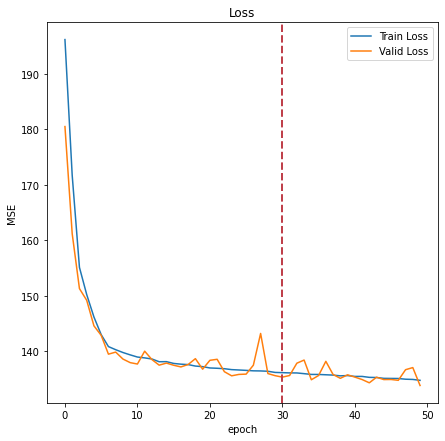

In [55]:

plt.figure(figsize=(7,7))

plt.plot(loss_,label='Train Loss')
plt.plot(valid_loss,label='Valid Loss')

plt.axvline(30, color='#bf404b', linestyle='--', linewidth=2)

plt.legend()
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.show()

In [56]:
test_mse = evaluation(test_loader)

print(f'train last mse:{loss_[-1]}')
print(f'valid last mse:{valid_loss[-1]}')
print(f'test mse:{test_mse}')

# 데이터 수가 많다보니, 과적합 없이 모두 비슷한 loss를 가지게 됬음.


train last mse:134.70492498703075
valid last mse:133.77017211914062
test mse:131.9339141845703


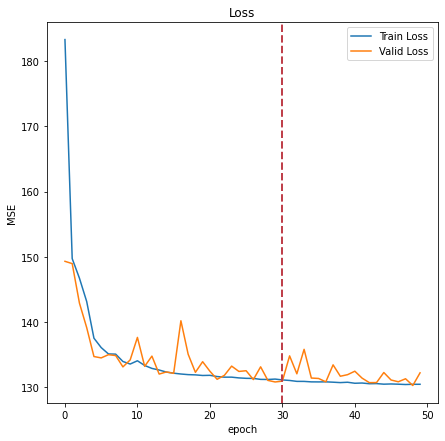

In [47]:

plt.figure(figsize=(7,7))

plt.plot(loss_,label='Train Loss')
plt.plot(valid_loss,label='Valid Loss')

plt.axvline(30, color='#bf404b', linestyle='--', linewidth=2)

plt.legend()
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.show()

In [45]:
test_mse = evaluation(test_loader)

print(f'train last mse:{loss_[-1]}')
print(f'valid last mse:{valid_loss[-1]}')
print(f'test mse:{test_mse}')

# 데이터 수가 많다보니, 과적합 없이 모두 비슷한 loss를 가지게 됬음.


train last mse:130.37740041281356
valid last mse:132.13531494140625
test mse:131.00267028808594


findfont: Font family ['New Gulim'] not found. Falling back to DejaVu Sans.
findfont: Font family ['New Gulim'] not found. Falling back to DejaVu Sans.


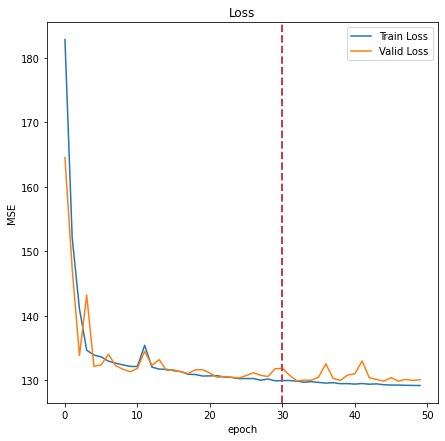

In [20]:

plt.figure(figsize=(7,7))

plt.plot(loss_,label='Train Loss')
plt.plot(valid_loss,label='Valid Loss')

plt.axvline(30, color='#bf404b', linestyle='--', linewidth=2)

plt.legend()
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.show()

In [21]:
test_mse = evaluation(test_loader)

print(f'train last mse:{loss_[-1]}')
print(f'valid last mse:{valid_loss[-1]}')
print(f'test mse:{test_mse}')

# 데이터 수가 많다보니, 과적합 없이 모두 비슷한 loss를 가지게 됬음.


train last mse:129.1881435547604
valid last mse:130.07559204101562
test mse:128.71005249023438
